<a href="https://colab.research.google.com/github/snakeway8/Projects/blob/main/Income_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics and evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc



# Statistical tools
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt



# Remove warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('/content/data_clean.csv')

In [3]:
df.head()

,age,capitalgain,capitalloss,gender,hoursperweek,region,occupation_grouped,marital_grouped,job_type_grouped,target,Salary
0,45,0,0,Female,28,North America,White-collar,Separated,Private,0,"less than or equal to 50,000"
1,24,0,0,Male,40,North America,Blue-collar,Single,Government,0,"less than or equal to 50,000"
2,44,0,0,Male,40,North America,White-collar,Married,Private,1,"greater than 50,000"
3,27,0,0,Male,40,North America,Blue-collar,Single,Private,0,"less than or equal to 50,000"
4,20,0,0,Male,35,North America,White-collar,Single,Private,0,"less than or equal to 50,000"


### Data Prep & EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31978 entries, 0 to 31977
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 31978 non-null  int64 
 1   capitalgain         31978 non-null  int64 
 2   capitalloss         31978 non-null  int64 
 3   gender              31978 non-null  object
 4   hoursperweek        31978 non-null  int64 
 5   region              31978 non-null  object
 6   occupation_grouped  31978 non-null  object
 7   marital_grouped     31978 non-null  object
 8   job_type_grouped    31978 non-null  object
 9   target              31978 non-null  int64 
 10  Salary              31978 non-null  object
dtypes: int64(5), object(6)
memory usage: 2.7+ MB


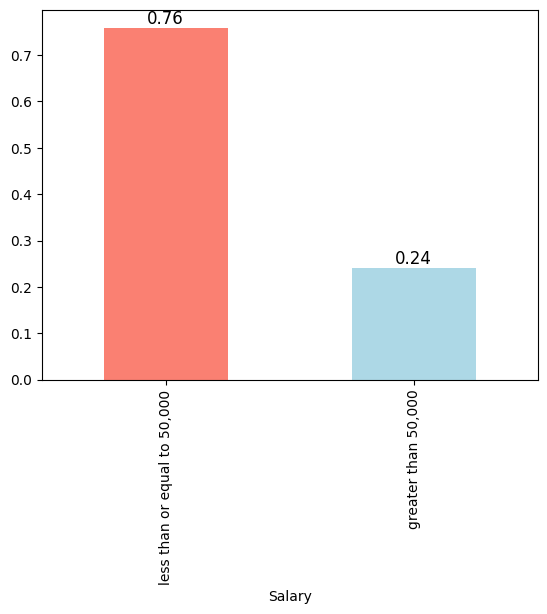

In [5]:

ax = df['Salary'].value_counts(normalize=True).plot(kind='bar', color=['salmon', 'lightblue'])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f'{p.get_height():.2f}',
            ha='center', va='bottom', fontsize=12)

plt.show()

In [7]:
#target 1- annual salary greater than 50 000, 0- less than 50 000

region_salary_group = df[df['region']!='Unknown'].groupby(['region','gender']).agg(mean_target=('target','mean'))

region_salary_group

mean_target
region                      gender             
Asia                        Female     0.170854
                            Male       0.364407
Central America & Caribbean Female     0.049261
                            Male       0.173745
Europe                      Female     0.163934
                            Male       0.360947
North America               Female     0.109309
                            Male       0.306416
South America               Female     0.000000
                            Male       0.112676

In all regions, the proportion of men  earning over 50,000 is significantly higher than women. The data shows that women in South America dont have annual salary greater than 50,000.

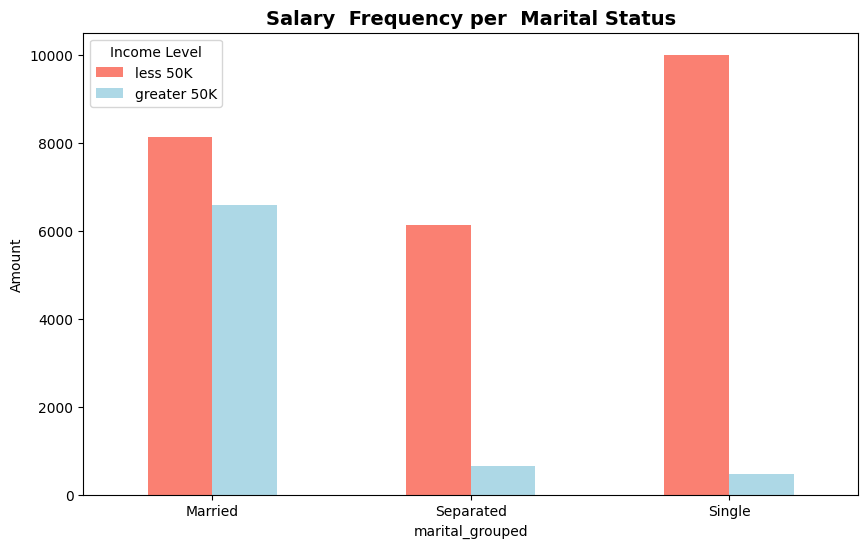

In [8]:
ax = pd.crosstab(df.marital_grouped	,df.target).plot(kind='bar', figsize = (10,6),color=['salmon','lightblue'])
plt.title('Salary  Frequency per  Marital Status',fontsize=14, fontweight='bold')
plt.ylabel('Amount')
ax.legend(["less 50K","greater 50K"], title="Income Level")
plt.xticks(rotation=0);

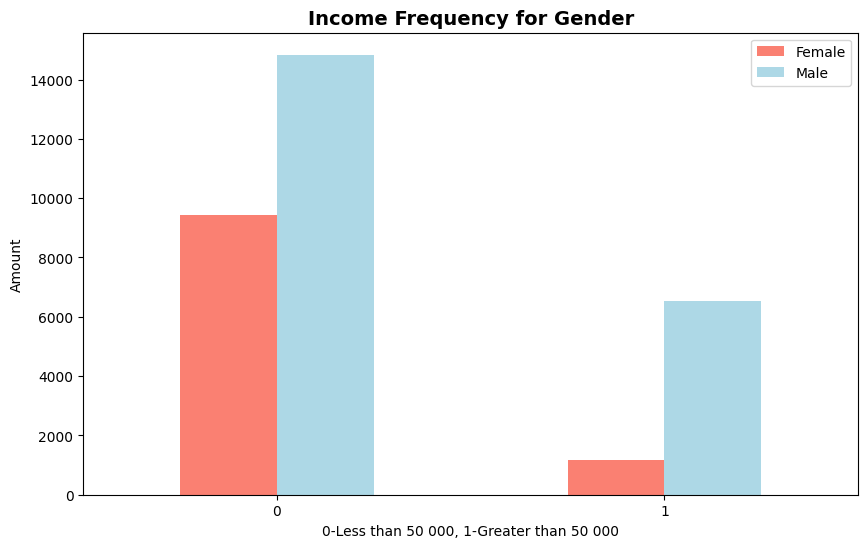

In [9]:
pd.crosstab(df.target, df.gender).plot(kind='bar', figsize = (10,6),color=['salmon','lightblue'])
plt.title('Income Frequency for Gender',fontsize=14, fontweight='bold')
plt.ylabel('Amount')
plt.xlabel('0-Less than 50 000, 1-Greater than 50 000')
plt.legend(['Female','Male'])
plt.xticks(rotation=0);

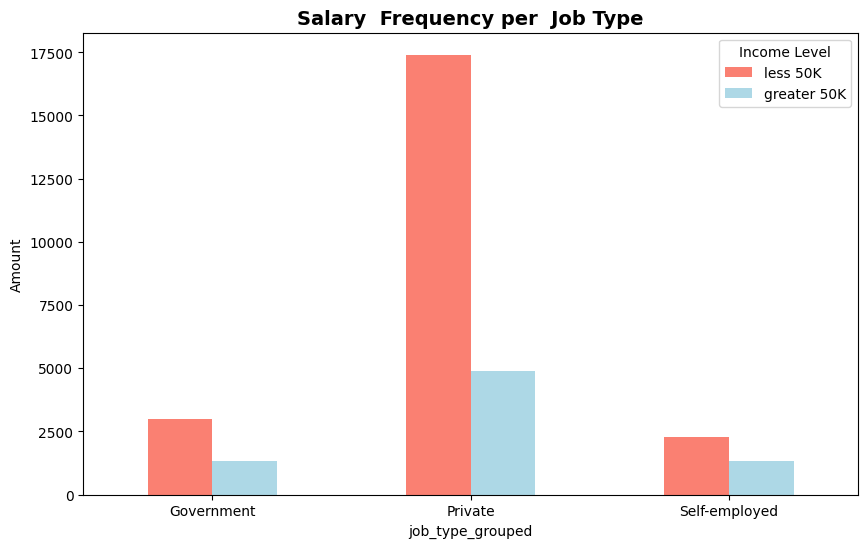

In [16]:
ax = pd.crosstab(df[df['job_type_grouped']!='Unknown'].job_type_grouped	,df.target).plot(kind='bar', figsize = (10,6),color=['salmon','lightblue'])
plt.title('Salary  Frequency per  Job Type',fontsize=14, fontweight='bold')
plt.ylabel('Amount')

plt.xticks(rotation=0);
ax.legend([ "less 50K","greater 50K"], title="Income Level");

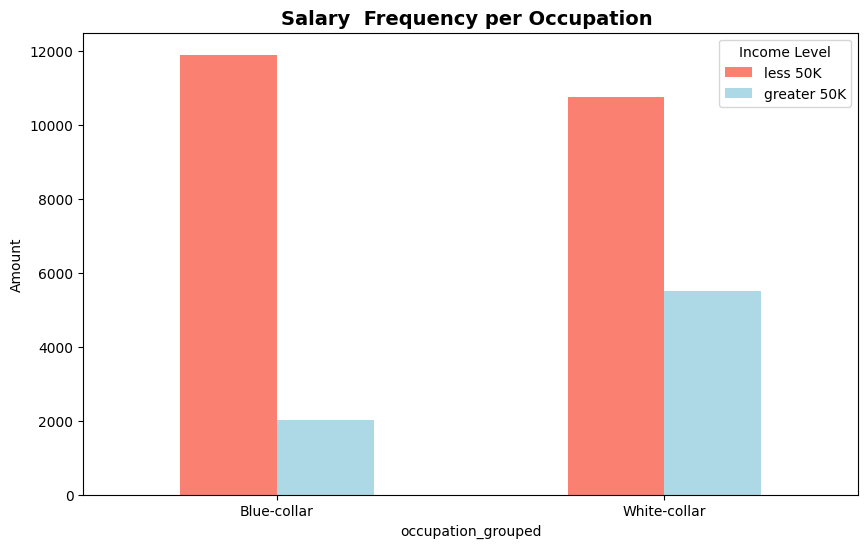

In [15]:
ax = pd.crosstab(df[df['occupation_grouped']!='Unknown'].occupation_grouped	,df.target).plot(kind='bar', figsize = (10,6),color=['salmon','lightblue'])
plt.title('Salary  Frequency per Occupation ',fontsize=14, fontweight='bold')
plt.ylabel('Amount')

plt.xticks(rotation=0)
ax.legend([ "less 50K","greater 50K"], title="Income Level");

In [14]:
df[df['occupation_grouped']!='Unknown'].groupby(['occupation_grouped','gender']).agg(number_person = ('gender','count'),\
                                                                                     mean_hoursperweek=('hoursperweek','mean')
                                                                                     ).round(2)

number_person  mean_hoursperweek
occupation_grouped gender                                  
Blue-collar        Female           3047              35.23
                   Male            10868              41.84
White-collar       Female           6735              37.70
                   Male             9512              44.00

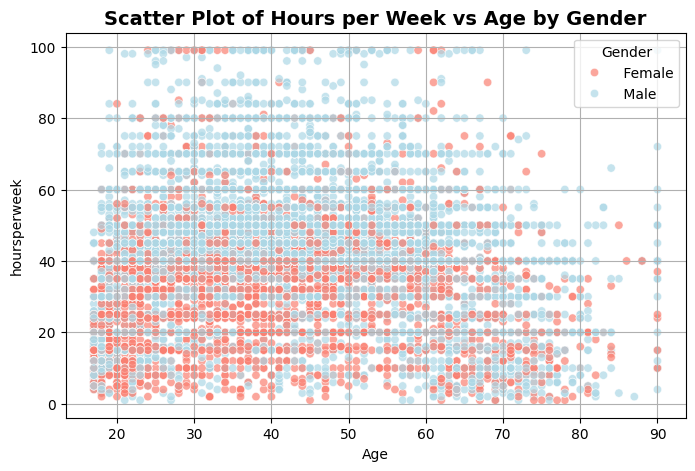

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='age', y='hoursperweek', hue='gender', alpha=0.7, palette=['salmon', 'lightblue'])

plt.xlabel('Age')
plt.ylabel('hoursperweek')
plt.title('Scatter Plot of Hours per Week vs Age by Gender', fontsize=14, fontweight='bold')
plt.legend(title='Gender')
plt.grid(True)
plt.show()



Men generally have a wider spread of working hours, with more individuals working extreme hours.

Women tend to be concentrated in the lower work hour ranges and show an earlier decline in working hours with age.

In [18]:
job_type_gender_grouped = df[df['job_type_grouped'] != 'Unknown'].groupby(['job_type_grouped', 'gender'])['gender'].count().reset_index(name='count')

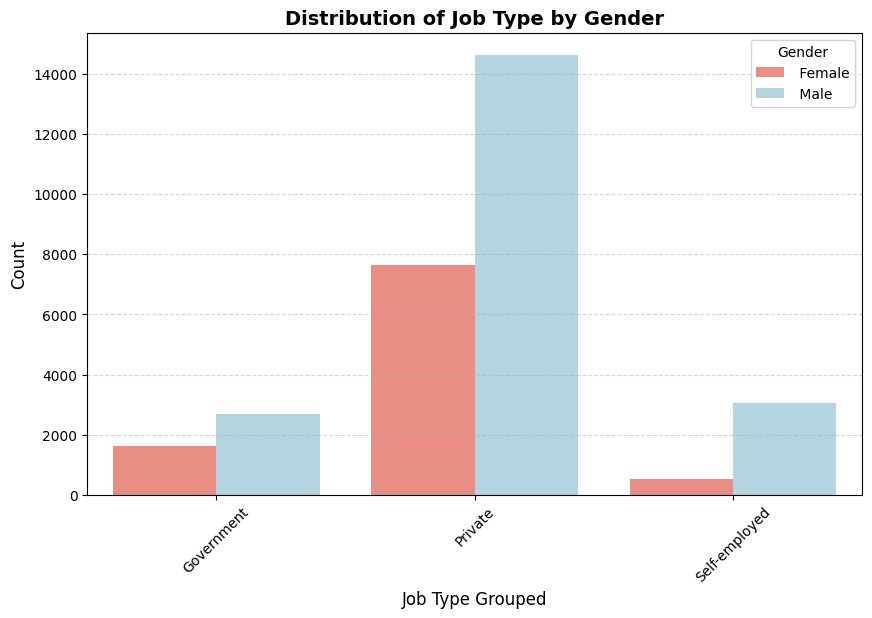

In [19]:

plt.figure(figsize=(10, 6))
sns.barplot(data=job_type_gender_grouped, x='job_type_grouped', y='count', hue='gender', palette=['salmon', 'lightblue'])

plt.xlabel('Job Type Grouped', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Job Type by Gender', fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

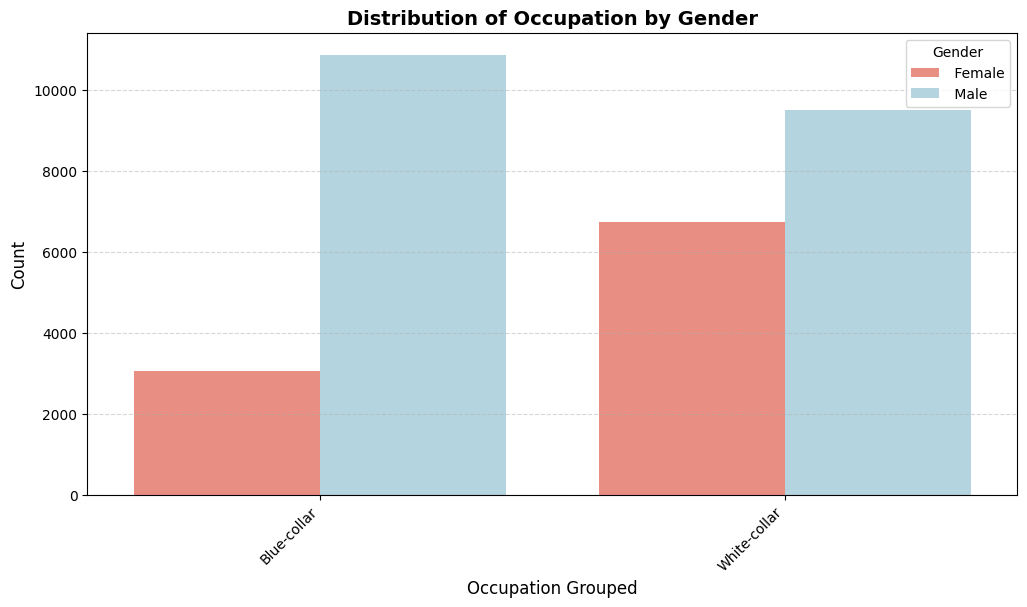

In [20]:



ocuupation_gender_grouped = (
    df[df['occupation_grouped'] != 'Unknown']
    .groupby(['occupation_grouped', 'gender'])['gender']
    .count()
    .reset_index(name='count')
)


plt.figure(figsize=(12, 6))
sns.barplot(data=ocuupation_gender_grouped, x='occupation_grouped', y='count', hue='gender', palette=['salmon', 'lightblue'])

plt.xlabel('Occupation Grouped', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Occupation by Gender', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

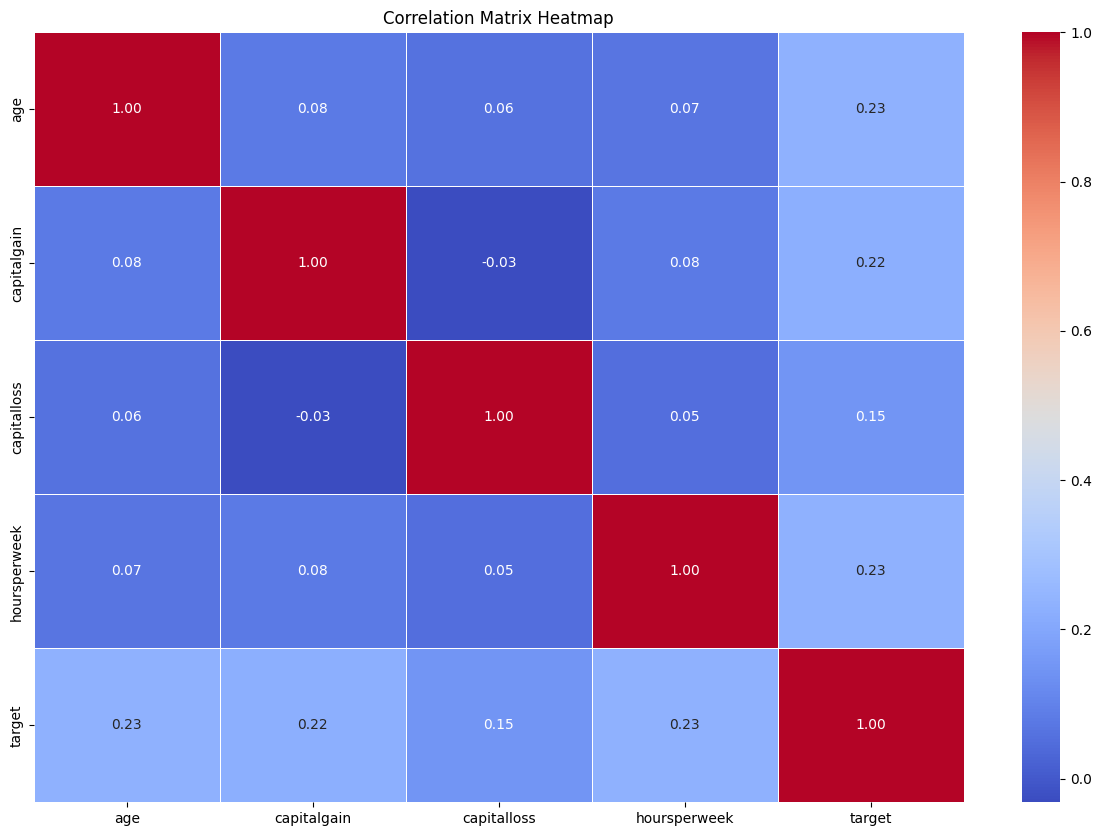

In [21]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)


plt.title("Correlation Matrix Heatmap")

In [22]:

scaler = StandardScaler()

columns_to_scale = ['age', 'capitalgain', 'capitalloss',  'hoursperweek', ]
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [23]:
# Encoding categorical columns
data_encoded= pd.get_dummies(df, columns=[ 'gender',  'region',
      'occupation_grouped', 'marital_grouped',
       'job_type_grouped'],dtype=int)

In [24]:
data_encoded.drop(columns = 'Salary', inplace= True)

In [25]:
data_encoded.columns

Index(['age', 'capitalgain', 'capitalloss', 'hoursperweek', 'target',
       'gender_ Female', 'gender_ Male', 'region_Asia',
       'region_Central America & Caribbean', 'region_Europe',
       'region_North America', 'region_South America', 'region_Unknown',
       'occupation_grouped_Blue-collar', 'occupation_grouped_Unknown',
       'occupation_grouped_White-collar', 'marital_grouped_Married',
       'marital_grouped_Separated', 'marital_grouped_Single',
       'job_type_grouped_Government', 'job_type_grouped_Private',
       'job_type_grouped_Self-employed', 'job_type_grouped_Unknown'],
      dtype='object')

In [26]:

#selected only the variables where VIF < 5

X = data_encoded[[
   'age', 'capitalgain', 'capitalloss', 'hoursperweek',
        'gender_ Male',
              'region_Central America & Caribbean',
        'region_South America',
     'occupation_grouped_White-collar', 'marital_grouped_Married',

      'job_type_grouped_Self-employed'

]]

y = data_encoded['target']

In [27]:

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Feature,VIF
0,age,1.120293
1,capitalgain,1.019658
2,capitalloss,1.010452
3,hoursperweek,1.045408
4,gender_ Male,2.485094
5,region_Central America & Caribbean,1.008651
6,region_South America,1.002528
7,occupation_grouped_White-collar,1.422262
8,marital_grouped_Married,2.509044
9,job_type_grouped_Self-employed,1.202445


In [28]:
# Selection of parameters that influence the model where p-value < 0.05.
X_const = sm.add_constant(X)


model = sm.Logit(y, X_const)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.352569
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                31978
Model:                          Logit   Df Residuals:                    31967
Method:                           MLE   Df Model:                           10
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                  0.3611
Time:                        05:14:55   Log-Likelihood:                -11274.
converged:                       True   LL-Null:                       -17646.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -3.6823      0.053    -70.021      0.000      -3.785      -3.579
age                                    0.3433      0.019     18.134      0.000       0.306       0.380
capitalgain                            2.3310      0.070     33.118      0.000       2.193       2.469
capitalloss                            0.2806      0.014     19.874      0.000       0.253       0.308
hoursperweek                           0.4195      0.018     22.707      0.000       0.383       0.456
gender_ Male                           0.3467      0.048      7.270      0.000       0.253       0.440
region_Central America & Caribbean    -0.5092      0.175     -2.909      0.004      -0.852      -0.166
region_South America                  -1.3351      0.429     -3.112      0.002      -2.176      -0.494
occupation_grouped_White-collar        1.4115      0.036     39.646      0.000       1.342       1.481
marital_grouped_Married                2.3564      0.045     52.279      0.000       2.268       2.445
job_type_grouped_Self-employed        -0.2967      0.049     -6.017      0.000      -0.393      -0.200
======================================================================================================
"""

### Selection of a classification model and tuned the hyperparameters

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

models = {"Logistic Regression": LogisticRegression(),
          "RandomForest Classifier":RandomForestClassifier(),
          "GradientBoostingClassifier":GradientBoostingClassifier(n_estimators=200)}


def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        model_scores[name] = {
            "Train Accuracy": model.score(X_train, y_train),
            "Test Accuracy": model.score(X_test, y_test),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)
        }

    return model_scores

model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'Logistic Regression': {'Train Accuracy': 0.8357047924321789,
  'Test Accuracy': 0.8356785490931833,
  'Precision': 0.6918335901386748,
  'Recall': 0.579728857327308,
  'F1 Score': 0.6308394801545486},
 'RandomForest Classifier': {'Train Accuracy': 0.9052067860214214,
  'Test Accuracy': 0.8394308943089431,
  'Precision': 0.6880403458213257,
  'Recall': 0.6165267914783732,
  'F1 Score': 0.6503234593122234},
 'GradientBoostingClassifier': {'Train Accuracy': 0.8637714017668673,
  'Test Accuracy': 0.859443402126329,
  'Precision': 0.7477134146341463,
  'Recall': 0.6333118140735958,
  'F1 Score': 0.6857742048234883}}

Since Random Forest already shows signs of overfitting, tuning might not significantly improve its performance, whereas Logistic Regression and Gradient Boosting have more potential for optimization

In [30]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "C": np.linspace(.1, 1.1, 11),
    "penalty": ["l1", "l2"],
}

gridsearch = GridSearchCV(LogisticRegression(solver="saga", max_iter=1000), parameters)

gridsearch.fit(X_train, y_train)

gridsearch.best_params_

{'C': np.float64(0.6), 'penalty': 'l1'}

In [31]:
logreg = LogisticRegression(max_iter=5000,solver = 'liblinear', **gridsearch.best_params_)

lr_tuned = logreg.fit(X_train, y_train)

In [32]:
print(f"Train Accuracy: {lr_tuned.score(X_train, y_train)}")
print(f"Test Accuracy: {lr_tuned.score(X_test, y_test)}")

Train Accuracy: 0.835470252521304
Test Accuracy: 0.8359912445278299


<Axes: >

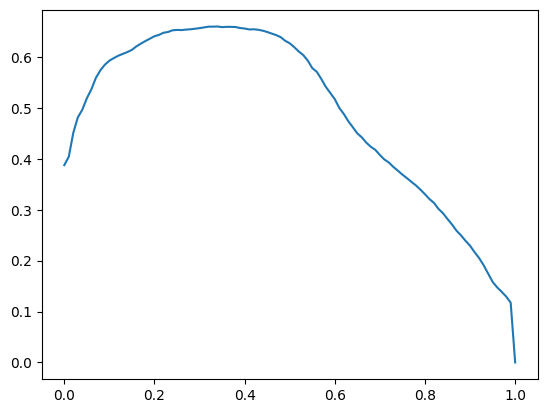

In [33]:
f1 = []

thresholds = np.linspace(0, 1, 101)

for thresh in thresholds:
    y_pred =(lr_tuned.predict_proba(X_train)[:,1]>thresh)
    f1.append(f1_score(y_train, y_pred))

sns.lineplot(x=thresholds, y=f1)

In [34]:
thresh = thresholds[f1.index(max(f1))]

thresh

np.float64(0.34)

In [35]:
preds = lr_tuned.predict_proba(X_test)[:, 1] > thresh

print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"F1: {f1_score(y_test, preds)}")

Accuracy: 0.8248905565978737
Precision: 0.6207090602138435
Recall: 0.7120723047127179
F1: 0.6632591701743836


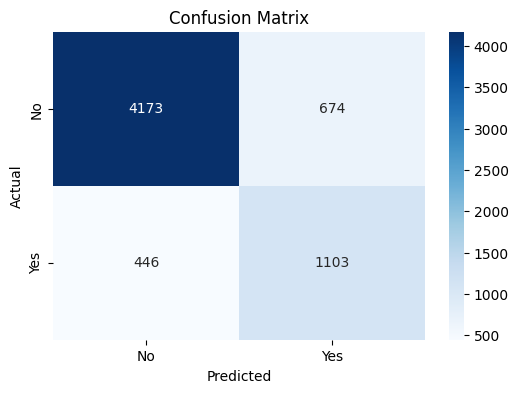

In [36]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

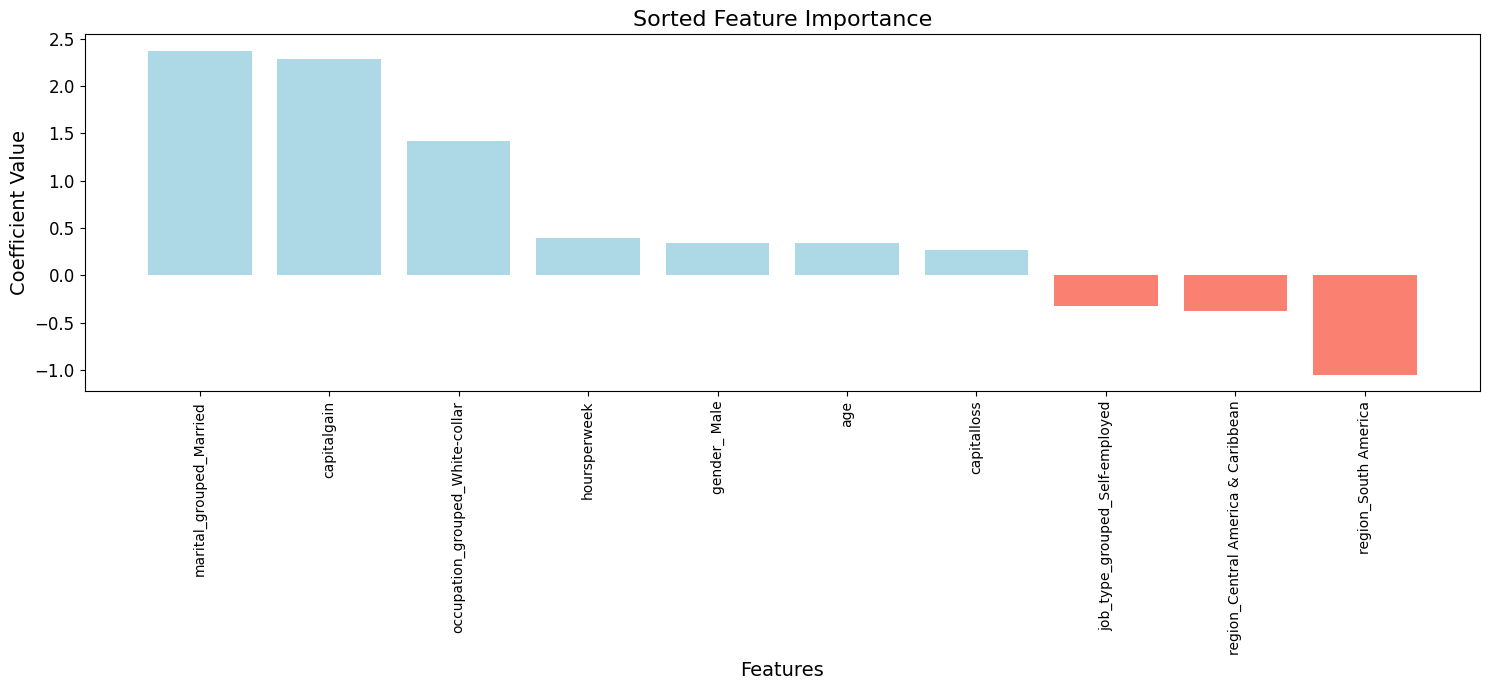

In [37]:
feature_dict = dict(zip(X.columns, lr_tuned.coef_[0]))


feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df = feature_df.T.sort_values(by=0, ascending=False)


plt.figure(figsize=(15, 7))


colors = ['salmon' if val < 0 else 'lightblue' for val in feature_df[0]]

plt.bar(feature_df.index, feature_df[0], color=colors)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Coefficient Value", fontsize=14)
plt.title("Sorted Feature Importance", fontsize=16)
plt.tight_layout()
plt.show()

The bar chart shows the importance of different features in predicting income.This suggests that marital status, financial assets, and occupation type are strong predictors of income level.

In [38]:

from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingClassifier(random_state=2023)

params = {
    'n_estimators': [20, 40, 60, 80, 100, 200],
    'learning_rate': [.01, .1],
    'max_features': ["sqrt"],
    'subsample': [.8, .9, .95],
    'max_depth': np.arange(start=3, stop=12, step=2),
    'min_samples_leaf': [2, 5, 10]
}

grid = RandomizedSearchCV(
    gb,
    params,
    n_iter=50,
    scoring="accuracy",
    verbose=3
)

grid.fit(X_train, y_train)

grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END learning_rate=0.01, max_depth=11, max_features=sqrt, min_samples_leaf=10, n_estimators=20, subsample=0.95;, score=0.760 total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=11, max_features=sqrt, min_samples_leaf=10, n_estimators=20, subsample=0.95;, score=0.760 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=11, max_features=sqrt, min_samples_leaf=10, n_estimators=20, subsample=0.95;, score=0.760 total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=11, max_features=sqrt, min_samples_leaf=10, n_estimators=20, subsample=0.95;, score=0.760 total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=11, max_features=sqrt, min_samples_leaf=10, n_estimators=20, subsample=0.95;, score=0.760 total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=10, n_estimators=40, subsample=0.8;, score=0.760 total time=   0.3s
[CV 2/5] END learning_rate=0

{'subsample': 0.95,
 'n_estimators': 200,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': np.int64(5),
 'learning_rate': 0.1}

In [39]:


gbm_tuned = GradientBoostingClassifier(
    random_state=2023,
    learning_rate=0.1,
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=10,
    n_estimators=200,
    subsample=0.95
)

gbm_tuned.fit(X_train, y_train)

print(f"Training Accuracy: {gbm_tuned.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {gbm_tuned.score(X_test, y_test):.4f}")


Training Accuracy: 0.8682
Test Accuracy: 0.8598


<Axes: >

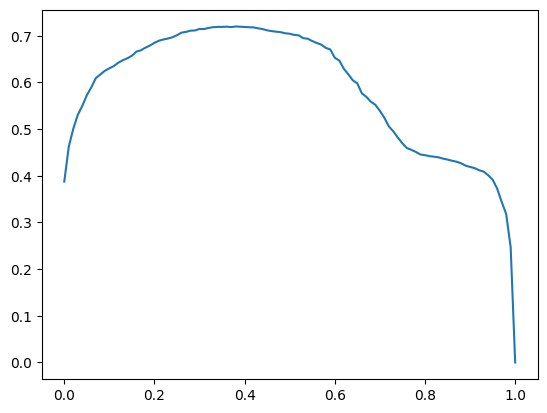

In [40]:

f1 = []

thresholds = np.linspace(0, 1, 101)

for thresh in thresholds:
    y_pred =(gbm_tuned.predict_proba(X_train)[:,1]>thresh)
    f1.append(f1_score(y_train, y_pred))

sns.lineplot(x=thresholds, y=f1)

In [41]:
thresh = thresholds[f1.index(max(f1))]

thresh

np.float64(0.38)

In [42]:
preds = gbm_tuned.predict_proba(X_test)[:, 1] > thresh

print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"F1: {f1_score(y_test, preds)}")

Accuracy: 0.8589743589743589
Precision: 0.704617330803289
Recall: 0.7191736604260813
F1: 0.7118210862619808


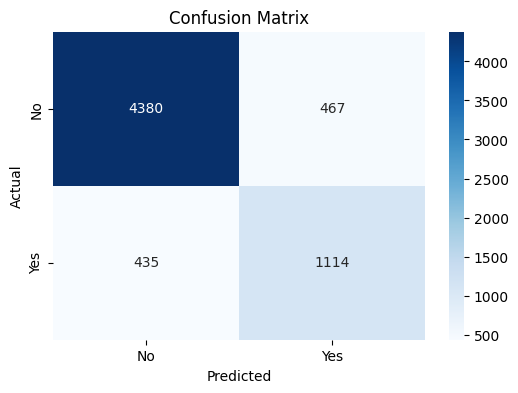

In [43]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

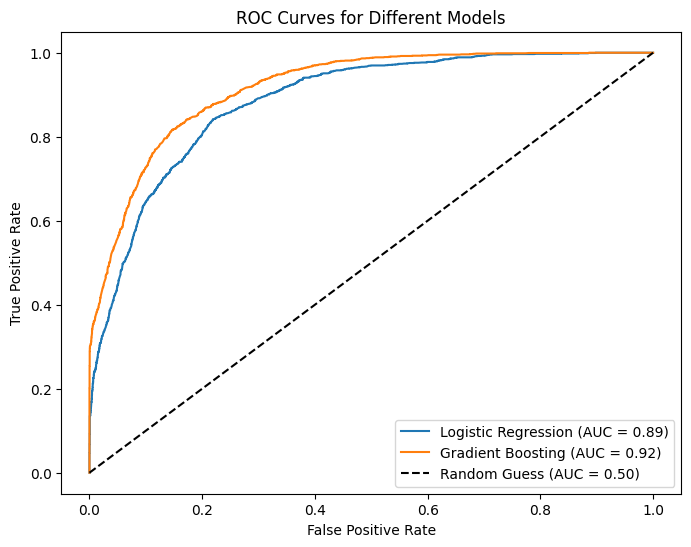

In [44]:



models = {
    "Logistic Regression": lr_tuned,

    "Gradient Boosting": gbm_tuned
}

plt.figure(figsize=(8, 6))


for name, model in models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()


Gradient Boosting (AUC = 0.92)  showing better classification performance.

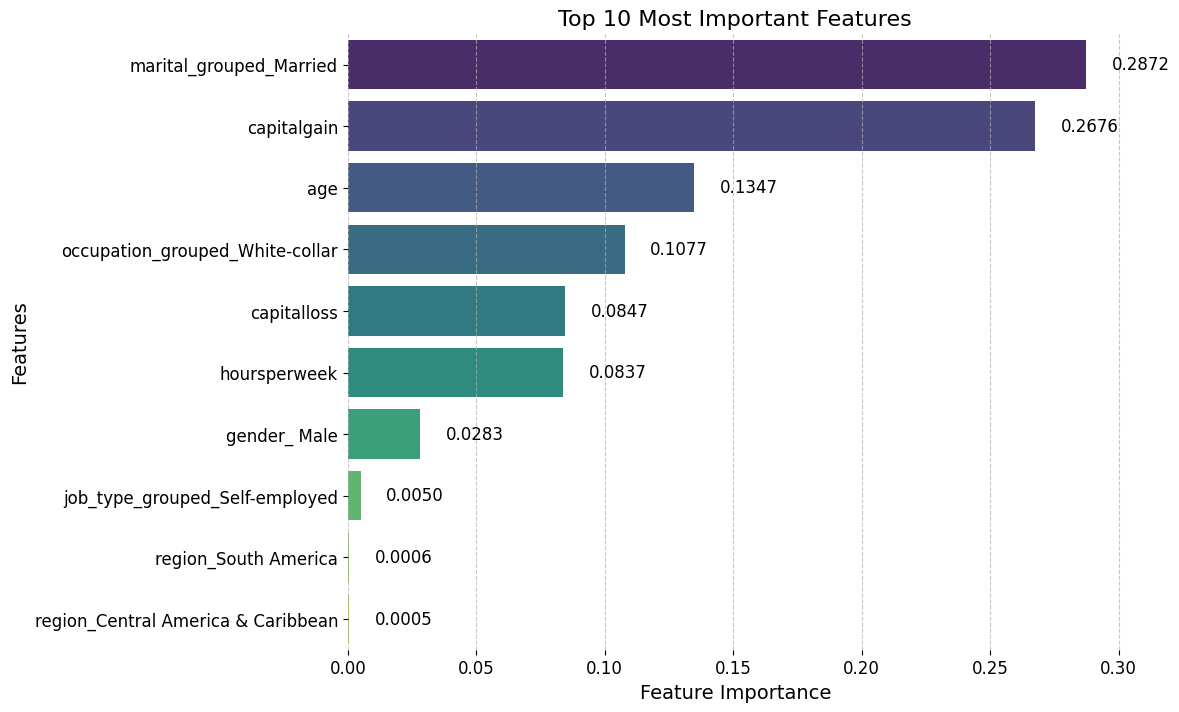

In [45]:


def plot_features(columns, importances, n=10):

    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))


    plt.figure(figsize=(10, 8))
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h",
                palette="viridis")

    plt.title(f"Top {n} Most Important Features", fontsize=16)
    plt.xlabel("Feature Importance", fontsize=14)
    plt.ylabel("Features", fontsize=14)


    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


    plt.grid(True, axis='x', linestyle='--', alpha=0.7)


    for i, v in enumerate(df[:n]["feature_importance"]):
        plt.text(v + 0.01, i, f"{v:.4f}", color='black', fontsize=12, va='center')


    sns.despine(left=True, bottom=True)


    plt.show()


plot_features(X_train.columns, gbm_tuned.feature_importances_)